In [1]:
!pip install tf-nightly

     |████████████████████████████████| 519.3MB 11kB/s 
     |████████████████████████████████| 3.0MB 65.4MB/s 
     |████████████████████████████████| 460kB 71.8MB/s 


In [2]:
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

Tensor Flow Verion: 2.2.0-dev20200422


'/device:GPU:0'

In [4]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
100% 10.8G/10.8G [04:18<00:00, 47.4MB/s]
100% 10.8G/10.8G [04:19<00:00, 45.0MB/s]


In [0]:
!unzip \*.zip

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

**Load the model**

In [8]:
cd /content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images

/content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images


In [0]:
model = tf.keras.models.load_model('MobileNet/saved_model/MobileNet_model')

**Add noise to test data**

Noise free

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
cd /content

/content


In [0]:
train_data_dir = 'OCT2017 /train'
validation_data_dir = 'OCT2017 /test'

In [0]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16
nb_train_samples = 83484
nb_validation_samples = 968

In [14]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [15]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
61/61 [==============================] - 4s 61ms/step - loss: 0.1087 - accuracy: 0.9597

Test result: 95.971 loss: 0.109


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [19]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Confusion Matrix
[[239   2   1   0]
 [  7 225   0  10]
 [ 12   2 223   5]
 [  0   0   0 242]]


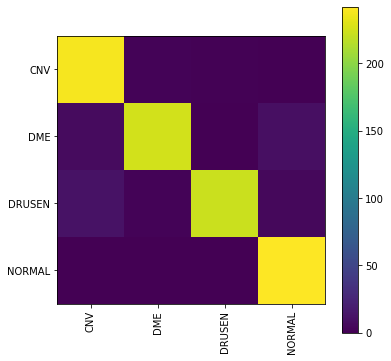

In [20]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [21]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       0.93      0.99      0.96       242
         DME       0.98      0.93      0.96       242
      DRUSEN       1.00      0.92      0.96       242
      NORMAL       0.94      1.00      0.97       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



Amplitude = 1

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [24]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [25]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 152ms/step - loss: 0.2858 - accuracy: 0.8554

Test result: 85.537 loss: 0.286


In [26]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[241   1   0   0]
 [ 20 212   0  10]
 [100   1 134   7]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.67      1.00      0.80       242
         DME       0.99      0.88      0.93       242
      DRUSEN       1.00      0.55      0.71       242
      NORMAL       0.93      1.00      0.97       242

    accuracy                           0.86       968
   macro avg       0.90      0.86      0.85       968
weighted avg       0.90      0.86      0.85       968



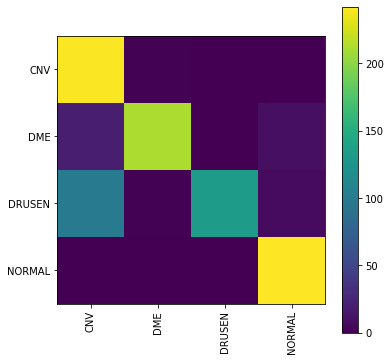

In [27]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 2

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=2):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [30]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [31]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.4380 - accuracy: 0.7913

Test result: 79.132 loss: 0.438


In [32]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[242   0   0   0]
 [ 22 210   0  10]
 [167   4  61  10]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.56      1.00      0.72       242
         DME       0.98      0.87      0.92       242
      DRUSEN       1.00      0.25      0.40       242
      NORMAL       0.92      1.00      0.96       242

    accuracy                           0.78       968
   macro avg       0.87      0.78      0.75       968
weighted avg       0.87      0.78      0.75       968



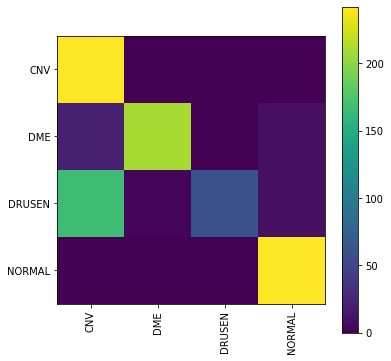

In [33]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 3

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=3):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [36]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [37]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 154ms/step - loss: 0.5406 - accuracy: 0.7531

Test result: 75.310 loss: 0.541


In [38]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[239   3   0   0]
 [ 22 212   0   8]
 [184   7  39  12]
 [  0   1   0 241]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.54      0.99      0.70       242
         DME       0.95      0.88      0.91       242
      DRUSEN       1.00      0.16      0.28       242
      NORMAL       0.92      1.00      0.96       242

    accuracy                           0.76       968
   macro avg       0.85      0.76      0.71       968
weighted avg       0.85      0.76      0.71       968



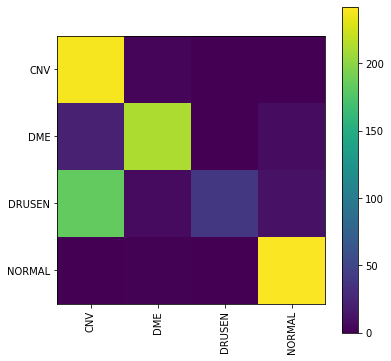

In [39]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 4

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=4):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [42]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [43]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 151ms/step - loss: 0.7126 - accuracy: 0.7128

Test result: 71.281 loss: 0.713


In [44]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[232  10   0   0]
 [ 22 211   0   9]
 [191  20  17  14]
 [  0   6   0 236]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.52      0.96      0.68       242
         DME       0.85      0.87      0.86       242
      DRUSEN       1.00      0.07      0.13       242
      NORMAL       0.91      0.98      0.94       242

    accuracy                           0.72       968
   macro avg       0.82      0.72      0.65       968
weighted avg       0.82      0.72      0.65       968



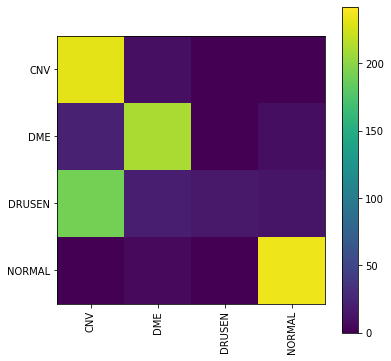

In [45]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 5

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=5):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [48]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [49]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 151ms/step - loss: 0.8731 - accuracy: 0.6932

Test result: 69.318 loss: 0.873


In [50]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[229  13   0   0]
 [ 24 211   0   7]
 [194  25   8  15]
 [  1  29   0 212]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.51      0.95      0.66       242
         DME       0.76      0.87      0.81       242
      DRUSEN       1.00      0.03      0.06       242
      NORMAL       0.91      0.88      0.89       242

    accuracy                           0.68       968
   macro avg       0.79      0.68      0.61       968
weighted avg       0.79      0.68      0.61       968



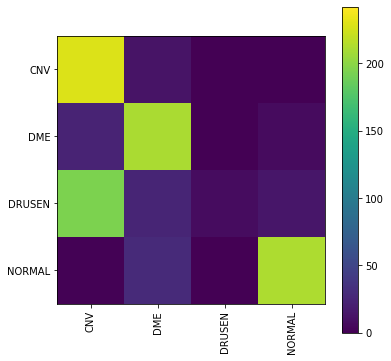

In [51]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 6

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=6):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [54]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [55]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 152ms/step - loss: 1.0552 - accuracy: 0.6498

Test result: 64.979 loss: 1.055


In [56]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[214  28   0   0]
 [ 31 205   0   6]
 [187  40   6   9]
 [  4  35   0 203]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.49      0.88      0.63       242
         DME       0.67      0.85      0.75       242
      DRUSEN       1.00      0.02      0.05       242
      NORMAL       0.93      0.84      0.88       242

    accuracy                           0.65       968
   macro avg       0.77      0.65      0.58       968
weighted avg       0.77      0.65      0.58       968



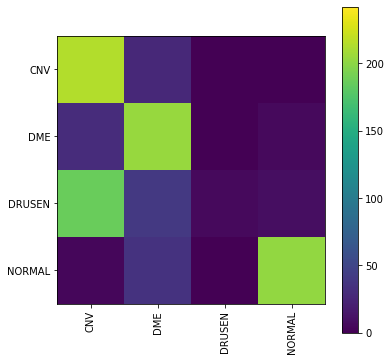

In [57]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 7

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=7):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [60]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [61]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 151ms/step - loss: 1.2421 - accuracy: 0.6074

Test result: 60.744 loss: 1.242


In [62]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[216  26   0   0]
 [ 38 201   0   3]
 [181  43   4  14]
 [ 11  66   0 165]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.48      0.89      0.63       242
         DME       0.60      0.83      0.70       242
      DRUSEN       1.00      0.02      0.03       242
      NORMAL       0.91      0.68      0.78       242

    accuracy                           0.61       968
   macro avg       0.75      0.61      0.53       968
weighted avg       0.75      0.61      0.53       968



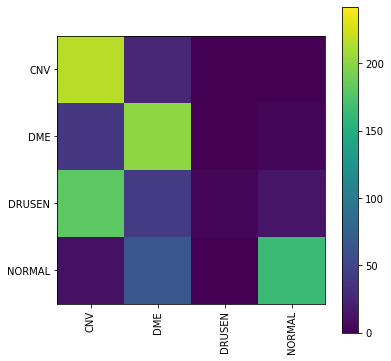

In [63]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 8

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=8):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [66]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [67]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 151ms/step - loss: 1.4347 - accuracy: 0.5537

Test result: 55.372 loss: 1.435


In [68]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[196  45   0   1]
 [ 52 188   0   2]
 [175  54   0  13]
 [ 21  75   0 146]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.44      0.81      0.57       242
         DME       0.52      0.78      0.62       242
      DRUSEN       0.00      0.00      0.00       242
      NORMAL       0.90      0.60      0.72       242

    accuracy                           0.55       968
   macro avg       0.47      0.55      0.48       968
weighted avg       0.47      0.55      0.48       968



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


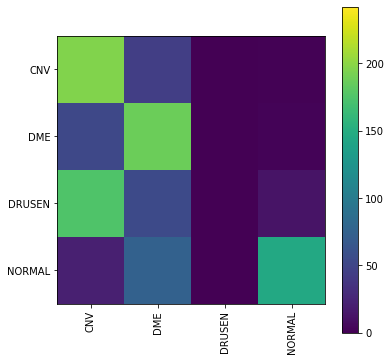

In [69]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))